In [1]:
import os
import cv2
from keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from keras.models import load_model
from keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
base_model= MobileNet(input_shape=(224,224,3), include_top= False)
for layer in base_model.layers:
    layer.trainable= False

x= Flatten()(base_model.output)
x= Dense(units=7, activation='softmax')(x)
model= Model(base_model.input, x)

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,580,103 (13.66 MB)

 Trainable params: 351,239 (1.34 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [5]:
train_datagen= ImageDataGenerator(
    zoom_range= 0.2,
    shear_range= 0.2,
    horizontal_flip= True,
    rescale= 1/225
)
train_data= train_datagen.flow_from_directory(directory= "C:/Users/ayush/train",
                                              target_size= (224,224),
                                              batch_size= 32
                                             )
train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [6]:
val_datagen= ImageDataGenerator(rescale= 1/255)
val_data= val_datagen.flow_from_directory(directory= "C:/Users/ayush/train",
                                              target_size= (224,224),
                                              batch_size= 32
                                             )

Found 350 images belonging to 7 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


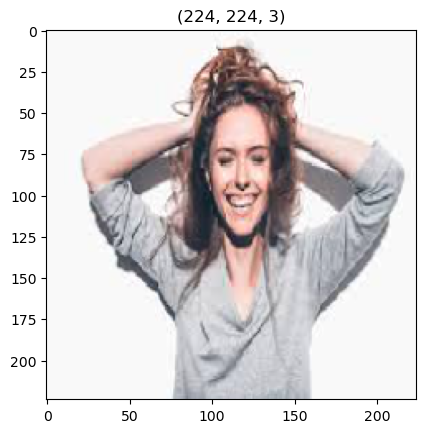

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


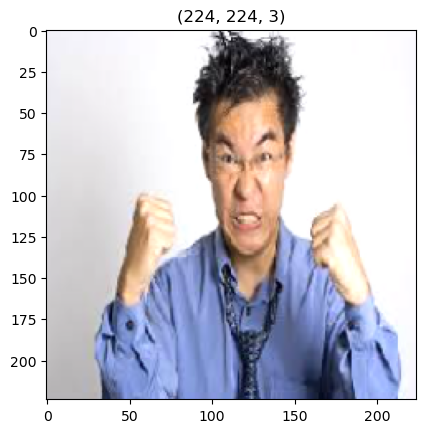

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


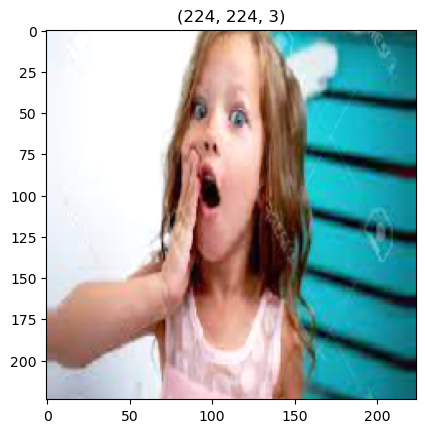

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


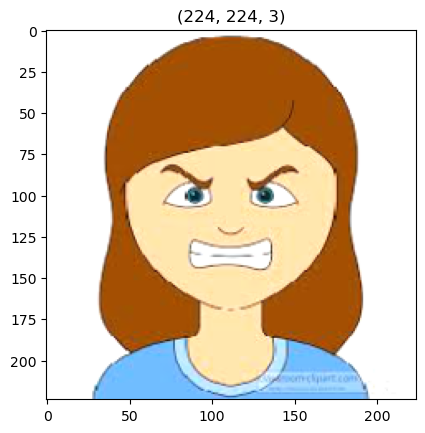

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


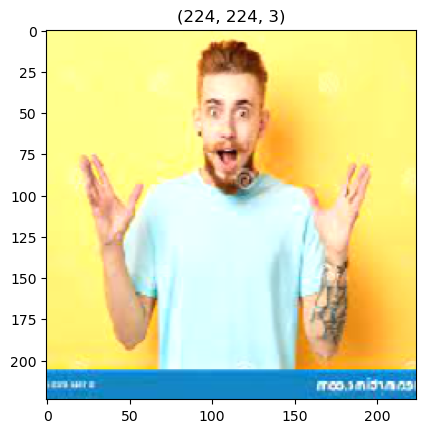

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


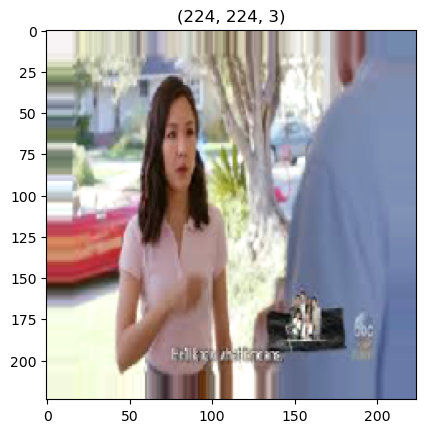

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


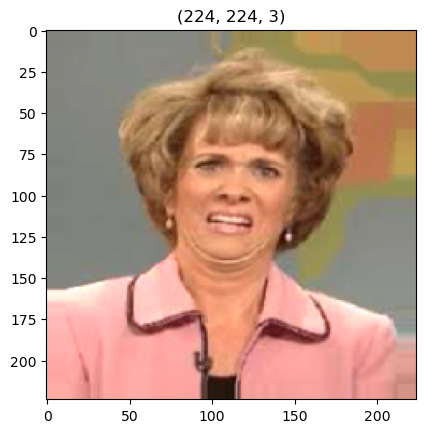

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


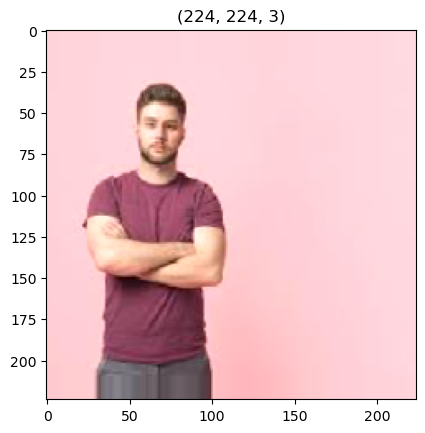

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


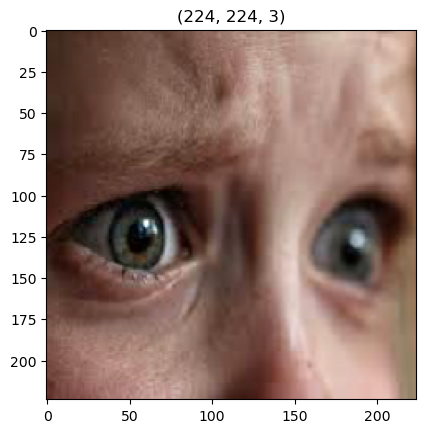

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


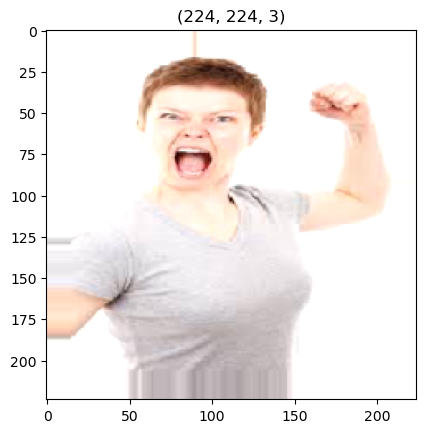

In [7]:
t_img, label= next(train_data)
def plotImages(img_arr, label):
    count=0
    for im, l in zip(img_arr, label):
        plt.imshow(im)
        plt.title(im.shape)
        plt.axis= False
        plt.show()
        count+= 1
        if count==10:
            break
plotImages(t_img, label)

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es= EarlyStopping(monitor='val_accuracy', min_delta= 0.01, patience=5, verbose= 1, mode= 'auto')
mc= ModelCheckpoint(filepath= "best_model.keras", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode= 'auto')
call_back= [es, mc]

In [9]:
hist= model.fit(train_data, 
                          steps_per_epoch= 10,
                          epochs= 30,
                          validation_data= val_data,
                          validation_steps= 8,
                          callbacks= [es, mc])

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1552 - loss: 10.1638
Epoch 1: val_accuracy improved from -inf to 0.57812, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.1571 - loss: 10.1919 - val_accuracy: 0.5781 - val_loss: 3.3200
Epoch 2/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 8s 940ms/step - accuracy: 0.3750 - loss: 5.0192
Epoch 2: val_accuracy did not improve from 0.57812
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.3750 - loss: 5.0192 - val_accuracy: 0.5319 - val_loss: 2.8497
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5466 - loss: 4.2048
Epoch 3: val_accuracy improved from 0.57812 to 0.66406, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5521 - loss: 4.1220 - val_accuracy: 0.6641 - val_loss: 2.6368
Epoch 4/30
 1/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5625 - loss: 3.7608
Epoch 4: val_accuracy improved from 0.66406 to 0.75532, saving model to best_model.keras
1

In [10]:
from keras.models import load_model
model= load_model("C:/Users/ayush/best_model.keras")

In [11]:
h= hist.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

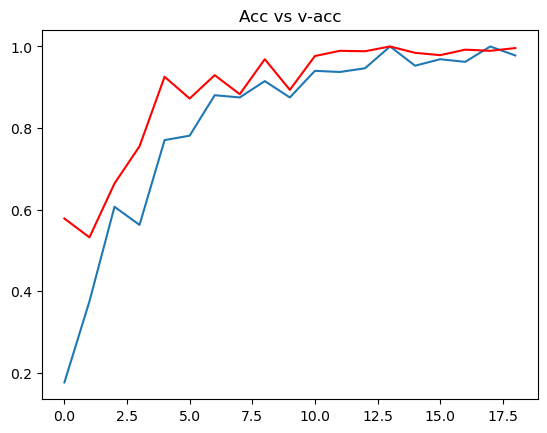

In [12]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title("Acc vs v-acc")
plt.show()

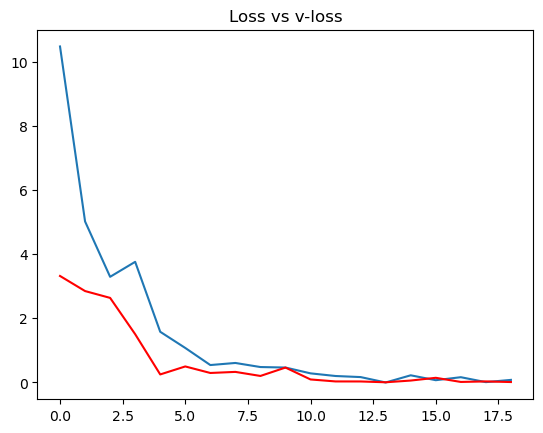

In [13]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c= "red")
plt.title("Loss vs v-loss")
plt.show()

In [14]:
op= dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step
The image is of Happy


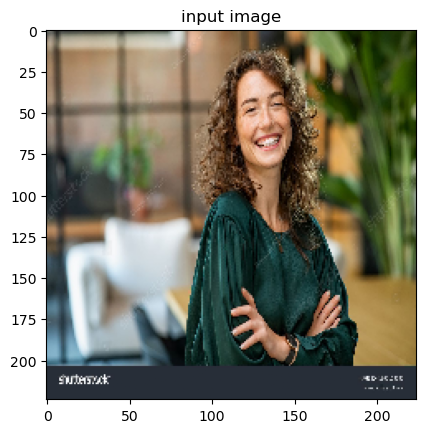

In [15]:
path= "C:/Users/ayush/download.jpg"
img= load_img(path, target_size= (224,224))
i= img_to_array(img)/255
input_arr= np.array([i])
input_arr.shape
pred= np.argmax(model.predict(input_arr))
print(f"The image is of {op[pred]}")
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

In [16]:
model= load_model("best_model.keras")

In [17]:
face_haar_cascade= cv2.CascadeClassifier(cv2.data.haarcascades+ 'haarcascade_frontalface_default.xml')

In [18]:
cap= cv2.VideoCapture(0)
while True:
    ret, test_img= cap.read()
    if not ret:
        continue
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)    
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)
    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img, (x,y), (x+w, y+h), (255,0,0), thickness=7)
        roi_gray = gray_img[y:y + w, x:x + h]
        roi_gray= cv2.resize(roi_gray, (224,224))
        img_pixels= image.img_to_array(roi_gray)
        img_pixels= np.expand_dims(img_pixels, axis=0)
        img_pixels /=255
        predictions= model.predict(img_pixels)
        max_index= np.argmax(predictions[0])
        emotions= ('angry', 'disgust','fear','happy','sad','surprise','neutral')
        predicted_emotion= emotions[max_index]
        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    resized_img= cv2.resize(test_img, (1000,700))
    cv2.imshow('Facial emotion analysis', resized_img)
    if cv2.waitKey(10)== ord('q'):
        break
cap.release()
cv2.destroyAllWindows

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━

<function destroyAllWindows>